In [1]:
from magpie import grasp as gt
import rtde_control
import rtde_receive
from magpie.motor_code import Motors
from magpie import ur5 as ur5
import time
import numpy as np
import copy
import magpie
from magpie.gripper import Gripper
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw
import signal

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()


In [3]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(pth=path)

2024-07-15 15:12:58.094237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 15:12:58.094263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 15:12:58.095173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 15:12:58.100686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 15:12:58.841796: W tensorflow/compiler/tf2

In [4]:
# indes = []

# def bound():
#     p, rgbd_image = rsc.getPCD()
#     image = np.array(rgbd_image.color)
#     queries = ["a photo of a green block"]
#     abbrevq = ["green_block"]
#     label_vit.set_threshold(0.005)
#     bboxes, uboxes = label_vit.label(image, queries, abbrevq, topk=True, plot=True)

#     bounding_boxes = []
#     for i in range(10):
#         bounding_boxes.append(label_vit.sorted_labeled_boxes_coords[i][0])

#     filtered_boxes = find_similar_boxes(bounding_boxes)

#     objects_of_interest = []

#     for i, group in enumerate(filtered_boxes):
#         for index, box in group:
#             rgbd_image, cpcd, tmat, pcaFrame = pcd.get_segment(
#                 label_vit.sorted_labeled_boxes_coords, 
#                 index, 
#                 rgbd_image, 
#                 rsc, 
#                 type="box-dbscan", 
#                 method="iterative", 
#                 display=False,
#                 viz_scale=1000)
            
#             indes.append(index)
#             area = calculate_area(box)
#             print(f"Group {i}, Index: {index}, Area: {area}")
#             objects_of_interest.append([cpcd, tmat])
            
#     return objects_of_interest

# def calculate_area(box):
#     return abs(box[3] - box[1]) * abs(box[2] - box[0])

# def find_similar_boxes(bounding_boxes, tolerance=0.15, min_count=3):
#     areas = [calculate_area(box) for box in bounding_boxes]
#     similar_groups = []
    
#     for i, area in enumerate(areas):
#         similar_boxes = [(i, bounding_boxes[i])]
#         for j in range(len(areas)):
#             if i != j and abs(areas[j] - area) <= tolerance * area:
#                 similar_boxes.append((j, bounding_boxes[j]))
#             if len(similar_boxes) >= min_count:
#                 break
#         if len(similar_boxes) >= min_count:
#             similar_groups.append(similar_boxes)
#             if len(similar_groups) == 1:
#                 break
    
#     return similar_groups


try:
    self.start()

    while uncertainty < ...
        return objects_of_interest
        for each object:
            self.transofrm
            store object name, segmented pcd, 
            get.center
            

In [5]:
# ur = ur5.UR5_Interface()
# merged_pcd = o3d.geometry.PointCloud()
# try:
#     ur.start()
#     for pose_num in range(2):
#         boxes = bound()
        

#         # rotation_matrix = np.array([[0, 1, 0, 0],
#         #                         [-1, 0, 0, 0],
#         #                         [0, 0, 1, 0],
#         #                         [0, 0, 0, 1]])

#         # # Transformation matrix for gripper length
#         # tmat_gripper = np.array([[1, 0, 0, -1.15/100],
#         #                         [0, 1, 0, 1.3/100],
#         #                         [0, 0, 1, (309.63 - 195.0)/1000],
#         #                         [0, 0, 0, 1]])

#         # # Get the transformation matrix of the end effector in the base frame

#         # ee_to_base = ur.get_tcp_pose()
#         # average = []
#         # for i in range(len(boxes)):
#         #     print(len(boxes))
#         #     cpcd, tmat= boxes[i]
#         #     cpcd.transform(tmat_gripper)  # Object to end effector frame
#         #     cpcd.transform(rotation_matrix)  # End effector to base frame
#         #     cpcd.transform(ee_to_base)  # End effector to base frame
#         #     center = cpcd.get_center()
#         #     center[2] = center[2] + 233/1000
#         #     average.append(center[2])
#         #     merged_pcd += cpcd
        
#         # average_center = np.mean(average)

#         # target_height= (ee_to_base[2][3] + average_center)*(2/3)

#         # target_pose = ur.get_tcp_pose()
#         # target_pose[2][3] = target_height
        
#         # print(f'The target height is {target_height}')
#         # print(f'Moving robot now to pose {pose_num + 1}')

#         # ur.moveL(target_pose)
#         # time.sleep(3)
#         # time.sleep(3)
#         # #pose_vector = [center[0], center[1], center[2], 3.14, 0, 0]
        
#     ur.stop()

# except Exception as e:
#     ur.stop()
#     raise e


In [6]:
# ur = ur5.UR5_Interface()
# try:
#     ur.start()
#     #load numpy home pose matrix
#     home = np.load("home_pose.npy")
#     ur.moveL(home)
#     print(ur.get_tcp_pose())
#     time.sleep(3)
#     time.sleep(3)
#     ur.stop()
#     print("Robot moved to home pose")
# except Exception as e:
#     ur.stop()
#     raise e

In [7]:
# o3d.visualization.draw_geometries([merged_pcd])

In [8]:
def handler(signum, frame):
    raise Exception("Task took too long")

In [9]:
temp = None
class Perception:
    def __init__(self, num_blocks, query, abbrevq):
        self.ur = ur5.UR5_Interface()
        self.merged_pcd = o3d.geometry.PointCloud()
        self.query = query
        self.abbrevq = abbrevq
        self.blocks = num_blocks
        self.sleep_rate = 3
        self.single_query = True
        self.object_pcd = {}
        
        
    def start_interface(self):
        self.ur.start()

    def stop_interface(self):
        self.ur.stop()

    def open_gripper(self):
        self.ur.open_gripper()

    def close_gripper(self):
        self.ur.close_gripper()

    def move_to_pose(self, pose):
        self.ur.moveL(pose)
        time.sleep(self.sleep_rate)
        time.sleep(self.sleep_rate)


    def get_pose(self):
        return self.ur.get_tcp_pose()
    
    def transform_point_cloud(self, cpcd):
        rotation_matrix = np.array([[0, 1, 0, 0],
                                    [-1, 0, 0, 0],
                                    [0, 0, 1, 0],
                                    [0, 0, 0, 1]])

        tmat_gripper = np.array([[1, 0, 0, -1.15 / 100],
                                 [0, 1, 0, 1.3 / 100],
                                 [0, 0, 1, (309.63 - 195.0) / 1000],
                                 [0, 0, 0, 1]])

        cpcd.transform(tmat_gripper)
        cpcd.transform(rotation_matrix)
        cpcd.transform(self.get_pose())

        return cpcd
    
    def save_point_cloud(self, filename, point_cloud):
         o3d.io.write_point_cloud(filename, point_cloud)

    def save_pose(self, filename, pose):
        np.save(filename, pose)
    
    def load_pose(self, filename):
        return np.load(filename)
    
    def return_to_home(self):
        home = np.load("home_pose.npy")
        self.move_to_pose(home)

    def visualize_point_cloud(self, point_cloud):
        o3d.visualization.draw_geometries([point_cloud])
    
    def calculate_area(self, box):
        return abs(box[3] - box[1]) * abs(box[2] - box[0])
    
    def find_similar_boxes(self, bounding_boxes, tolerance=0.5):
        self.blocks = self.blocks - 1

        areas = [self.calculate_area(box) for box in bounding_boxes]
        print(areas)
        similar_groups = []
        
        for i, area in enumerate(areas):

            similar_boxes = [(i, bounding_boxes[i])]
            for j in range(len(areas)):
                if i != j and abs(areas[j] - area) <= tolerance * area:
                    similar_boxes.append((j, bounding_boxes[j]))
                if len(similar_boxes) >= self.blocks:
                    break
            if len(similar_boxes) >= self.blocks:
                similar_groups.append(similar_boxes)
                if len(similar_groups) == 1:
                    break
        
        if not similar_groups:
            raise ValueError(f"No group with at least {self.blocks} similar areas found.")
                    
        
        return similar_groups
    

    def bound(self, query, abbrevq, use_area_calculation=True):

        p, rgbd_image = rsc.getPCD()
        
        image = np.array(rgbd_image.color)
        label_vit.set_threshold(0.002)
        label_vit.TOP_K = 10
        print("Labeling image...")
        bboxes, uboxes, scores = label_vit.label(image, query, abbrevq, topk=True, plot=True)
        print("Image labeled")
        #sort scores in descending order 
        scores = sorted(scores, reverse=True)

        objects_of_interest = []
        bounding_boxes = []
        
        slbc = label_vit.sorted_labeled_boxes_coords
        for i in range(3):
            # bounding_boxes.append(label_vit.sorted_labeled_boxes_coords[i][0])
            bounding_boxes.append(slbc[i][0])


        if use_area_calculation:
            filtered_boxes = self.find_similar_boxes(bounding_boxes)
            for i, group in enumerate(filtered_boxes):
                for index, box in group:
                    
                    try:
                        print("Starting segment operation...")
                        cpcd, tmat = self.segment(index, rgbd_image)
                        objects_of_interest.append([cpcd, tmat, scores[index]])
                        print("Segment operation completed")
                    except Exception as e:
                        print("Caught TimeoutError:", e)

        return objects_of_interest
   
    
    def segment(self, index, rgbd_image):

        rgbd_image, cpcd, tmat, pcaFrame = pcd.get_segment(
                    label_vit.sorted_labeled_boxes_coords, 
                    index, 
                    rgbd_image, 
                    rsc, 
                    type="box", 
                    method="iterative", 
                    display=False,
                    viz_scale=1000)
        
        return cpcd, tmat
        
    def build_model(self, n):
        try:
            self.start_interface()
            #self.return_to_home()

            for i in range(n):
                average = []
                if self.single_query:
                    boxes = self.bound(self.query, self.abbrevq)
                    for cpcd, tmat, score in boxes:
                        cpcd = self.transform_point_cloud(cpcd)

                else:
                    for j in range(len(self.query)):
                        boxes = self.bound(self.query[j], self.abbrevq[j])
                        for cpcd, tmat, score in boxes:
                            cpcd = self.transform_point_cloud(cpcd)
                            #self.temp_pcd[self.abbrevq[j]][f'Pose {i+1}'] = [cpcd, tmat, score]
                            #temp = self.temp_pcd
                            #print(temp)
                       
        except Exception as e:
            #self.stop_interface()
            raise e
        
    

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
Labeling image...
Post processing...
Done post processing.
Plot box
Image labeled
[765230.3594277328, 1743.163964302053, 23553.094689436875]
Starting segment operation...
modified indices: [0 2 2]
modified indices: [0 1 2]
z-axis dot product: [0.957]
Segment operation completed
Starting segment operation...
z-axis dot product: [1.]
Segment operation completed
Labeling image...
Post processing...
Done post processing.
Plot box
Image labeled
[768787.9821367315, 22461.495622409937, 1733.0298598141212]
Starting segment operation...
modified indices: [0 2 2]
modified indices: [0 1 2]
z-axis dot product: [0.955]
Segment operation completed
Labeling image...
Post processing...
Done post processing.
Plot box
Image labeled
[786720.211483771, 1703.4886615547862, 1839.40293783904]
Starting segment operation...
z-axis dot product: [0.984]
Segment operation complet

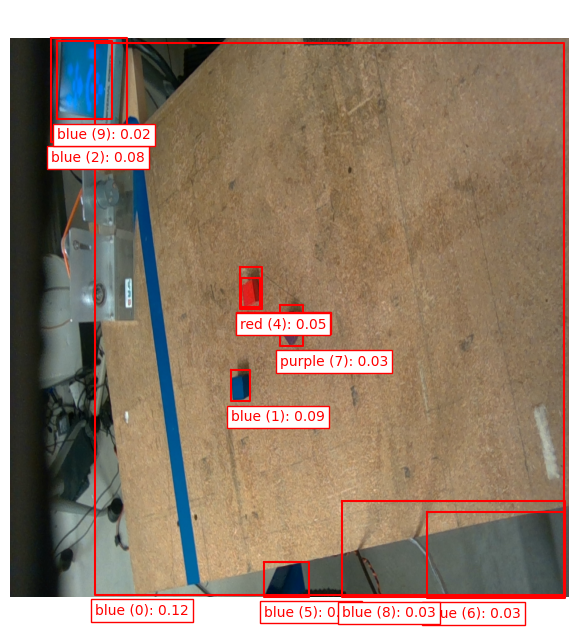

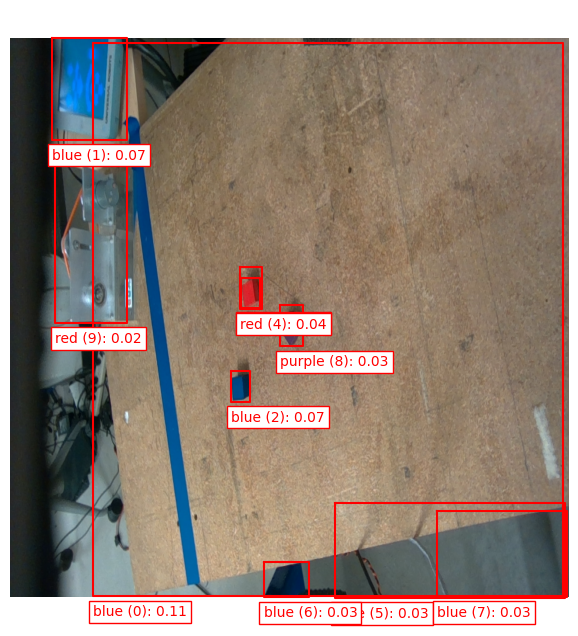

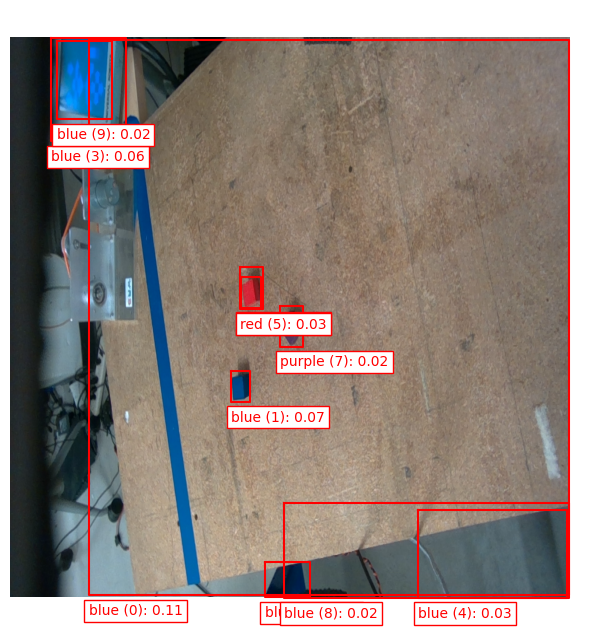

In [10]:
queries = ["a photo of a purple block", "a photo of a blue block", "a photo of a red block"]
abbrevq = ["purple", "blue", "red"]
num_blocks = 3
iterations_per_pose = 3

tower = Perception(num_blocks, queries, abbrevq)
tower.build_model(iterations_per_pose)

In [11]:
# #load pcd file and visualize
# ppcd = o3d.io.read_point_cloud("merged_pcd.pcd")
# o3d.visualization.draw_geometries([ppcd])

In [12]:

        # scores = []
        # p, rgbd_image = rsc.getPCD()
        # image = np.array(rgbd_image.color)
        # label_vit.set_threshold(0.005)
        # print("Labeling image...")
        # try:
        #     bboxes, uboxes, scores = label_vit.label(image, query, abbrevq, topk=True, plot=True)
        #     print("Image labeled")
        #     signal.alarm(0)
        # except TimeoutError as e:
        #             print("Caught TimeoutError:", e)
                    
        # scores = sorted(scores, reverse=True)
        # objects_of_interest = []
        # bounding_boxes = []
        # for i in range(5):
        #     bounding_boxes.append(label_vit.sorted_labeled_boxes_coords[i][0])

        # if use_area_calculation:
        #     filtered_boxes = self.find_similar_boxes(bounding_boxes)
        #     for i, group in enumerate(filtered_boxes):
        #         for index, box in group:
                    
        #             try:
        #                 print("Starting segment operation...")
        #                 cpcd, tmat = self.segment(index, rgbd_image)
        #                 objects_of_interest.append([cpcd, tmat, scores[index]])
        #                 print("Segment operation completed")
        #             except Exception as e:
        #                 print("Caught TimeoutError:", e)
                   
        # else:  
        #     filtered_boxes = bounding_boxes[:self.blocks]
        #     for i, group in enumerate(filtered_boxes):
        #         for box in group:
        #             try:
        #                 print("Starting segment operation...")
        #                 cpcd, tmat = self.segment(index, rgbd_image)
        #                 objects_of_interest.append([cpcd, tmat, scores[index]])
        #                 print("Segment operation completed")
        #             except Exception as e:
        #                 print("Caught TimeoutError:", e)
                        
                    

        # return objects_of_interest


#self.temp_pcd[f'Pose {n}'][f'Object {i}'] = [cpcd, tmat, scores[index]]

In [13]:
# queries = ["a photo of a purple block", "a photo of a blue block", "a photo of a red block"]
# abbrevq = ["purple","blue", "red"]

    
# def bound_test(queries, abbrevq):
#     p, rgbd_image = rsc.getPCD()
#     image = np.array(rgbd_image.color)
#     label_vit.set_threshold(0.005)
#     bboxes, uboxes, scores = label_vit.label(image, queries, abbrevq, topk=True, plot=True)
#     #sort scores in descending order 
#     scores = sorted(scores, reverse=True)
#     print(scores[:5])
    
   
# for i in range(3):
#     bound_test(queries[i], abbrevq[i])


       

In [14]:
ur5 = ur5.UR5_Interface()
try:    
    ur5.start()
    ur5.stop()
except Exception as e:
    ur5.stop()
    raise e

AttributeError: 'NoneType' object has no attribute 'servoStop'